# Dirac notation experiments
Solve using different transient non-line-of-sight algorithms using the Dirac notation

In [1]:
import numpy as np
import tal
import src.dirac_types as dirac
import src.dirac_io as io

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

Load the observations from the captured data. The results are:

<style>
td, th {
   border: none!important;
}
</style>

<table border="0">
 <tr>
    <td>T_mn[m, n, t] </td>
    <td> &rarr; </td>
    <td> Observations captured at the relay wall, for m sensors, with n illumination points, at time t </td>
 </tr>
 <tr>
   <td>ks[m] </td>
   <td>&rarr; </td>
   <td> Sensor at the relay wall positions</td>
 </tr>
 <tr>
   <td>offset_ks[m] </td><td>&rarr; </td><td>Distance for each sensor at the relay wall to the sensor device</td>
 </tr>
 <tr>
   <td>offset_kl[n] </td><td>&rarr; </td><td>Distance for each light source at the relay wall to the laser</td>
 </tr>
 <tr>
   <td>kt[t] &nbsp;&nbsp;</td><td>&rarr; </td><td>Time stamps for each moment k of the data</td>
 </tr>
</table>

<!-- - $ T_{mn}[m, n, t] $ &nbsp;&nbsp;&rarr;&nbsp; Observations captured at the relay wall, for m sensors, with n illumination points, at time t
- $ ks[m] $ &nbsp;&nbsp;&rarr; Sensor at the relay wall positions
- $ kl[n] $ &nbsp;&nbsp;&rarr; Light sources at the relay wall positions
- $ offset_{ks}[m] $ &rarr; Distance for each sensor at the relay wall to the sensor device
- $ offset_{kl}[n] $ &rarr; Distance for each light source at the relay wall to the laser
- $ kt[t] $ &nbsp;&nbsp;&rarr; Time stamps for each moment k of the data -->


In [2]:
T_mn, ks, kl, offset_ks, offset_kl, kt = io.read_observations('D:/Documentos/NLOS/nlos_dataset/mesh_R_256x256/front/data.hdf5')

## Quantum state observations
The observations are in the Real measurement. To transform them into the quantum state, it is used a change of basis.

### Illumination pulses

Illumination applied to the problem in the Fourier space. $\hat{l}(\mathbf{x}, t)$ represent the illumination $\mathbf{x}$ at time $t$.

In [3]:
hat_l = np.zeros((1, kt.shape[0]), dtype=complex)   # Illumination
illumination_tag = np.array([['No illumination']])  # Tag for plotting
freq = np.fft.fftfreq(kt.shape[0])                  # Frequencies
omega = np.fft.fftfreq(kt.shape[0])*2*np.pi         # Angular frequencies

#### Delta illumination pulse:

$$ l_n (\mathbf{x}, t) = \int_\mathbb{R} d \omega'\hat{l}_n(\mathbf{x})e^{i\omega'(t-t_n^{(0)})} = \hat{l}_n(x)\mathcal{F_{\omega'}}\left(e^{i\omega' t_n^{(0)}}\right)$$

$t_n^{(0)} = 0 \text{ps}$

In [4]:
# Delta illumination pulse at t=0
hat_l = np.append(hat_l, np.ones((1, omega.shape[0])), axis = 0)
illumination_tag = np.append(illumination_tag, [['Delta pulse at t=0ps']])

$t_n^{(0)} = 100\Delta t = 10 \text{ps}$

In [5]:
# Delta illumination pulse at t = 100
t_100 = np.array([[100.0]])
hat_l = np.append(hat_l, np.exp(-1j*omega*t_100), axis = 0)
illumination_tag = np.append(illumination_tag, [['Delta pulse at t=10ps']])

$t_n^{(0)} = 500\Delta t = 50 \text{ps}$

In [6]:
# Delta illumination pulse at t = 500
t_500 = np.array([[500.0]])
hat_l = np.append(hat_l, np.exp(-1j*omega*t_500), axis = 0)
illumination_tag = np.append(illumination_tag, [['Delta pulse at t=50ps']])

#### Box illumination pulse:

Box illumination pulse in the Fourier domain of amplitude $1/T$ and time duration $T$, centered at time 0:

$$ \hat{l}_n(\mathbf{x}, \omega) = \text{sinc} \left(T\frac{\omega}{2\pi}\right) $$

Box pulse of $5\text{ps}$ duration

In [7]:
# Box illumination pulse:
t_box_duration = np.array([[250]])
hat_l = np.append(hat_l, np.sinc(t_box_duration*freq), axis = 0)
illumination_tag = np.append(illumination_tag, [['Box pulse of duration 25ps']])


### Illuminated scene

#### Definition of the sensor
$$ s_m(\mathbf{x}, t) = \int_\mathbb{R} d\omega \hat{s}_m(\mathbf{x}, \omega) e^{i\omega t} $$

In [8]:
hat_s = np.fft.fft(T_mn.reshape((-1, T_mn.shape[-1])))

### Definition in the dirac notation

$\Ket{\hat{s}_m} $: ket of the $m$ sensors

$\Ket{\hat{l}_n} $: ket of the $n$ illumination points, so

$\Ket{\hat{l}_n} = \hat{l}(\mathbf{x},\omega) \to \{x_1, x_2, ..., x_n\} \in \mathbf{x} .$


In [9]:
ket_s = dirac.Ket(hat_s)
bra_s = ket_s.bra()
ket_l = dirac.Ket(hat_l)
bra_l = ket_l.bra()
ket_l_single = dirac.Ket(np.sum(hat_l, axis = 0)[None, ...])
bra_l_single = ket_l_single.bra()

$$ \hat{T}_{m,n} = \ket{\hat{s}_m} \bra{\hat{l}_n} $$
$$ \hat{T}_{m,n}^t = \ket{\hat{l}_n} \bra{\hat{s}_m} $$
$$ \bra{\hat{l}_n} \hat{T}_{m,n}^t = \ket{\hat{s}_n} \rightarrow \left(\bra{\hat{l}_n} \hat{T}_{m,n}^t\right)^\dagger = \bra{\hat{s}_n} $$

In [10]:
# vector of observations
hat_T_nm = ket_l*bra_s
hat_T_1m = ket_l_single*bra_s


In [11]:
# vector of sensors
s_m = hat_T_nm / ket_l
s_m_combined_l = hat_T_1m / ket_l_single

C:\Users\Pablo-L\AppData\Local\Temp\ipykernel_14300\3582094123.py:2: RuntimeWarning: invalid value encountered in divide
  s_m = hat_T_nm / ket_l


In [12]:
observations = np.moveaxis(dirac.dagger(hat_T_nm), 0, -1)
single_observation = np.moveaxis(dirac.dagger(hat_T_1m), 0, -1)

sensor_illuminated = np.moveaxis(dirac.dagger(s_m), 0, -1)
sensor_combined_illumination = np.moveaxis(dirac.dagger(s_m_combined_l), 0, -1)


## Plotting

In [13]:
def plot_pair_fourier_time(signal, common_title, tag_list):
    _, ax = plt.subplots(signal.shape[0], 2, figsize=(20, 4*signal.shape[0]))
    for i, t in enumerate(signal):
        if signal.shape[0] > 1:
            axs = ax[i]
        else:
            axs = ax
        axs[0].set_title('Fourier: ' + common_title + f' {i} - ' + tag_list[i])
        axs[0].plot(np.abs(t), label = 'Fourier real part')
        axs[0].plot(np.imag(t), label = 'Fourier imaginary part')
        axs[0].legend()
        axs[1].set_title('Time: ' + common_title + f' {i} - ' + tag_list[i])
        axs[1].plot(np.real(np.fft.ifft(t)), label='time signal')
        axs[1].legend()

    plt.show()

### Raw signal

$$ \ket{\hat{s}_m} $$

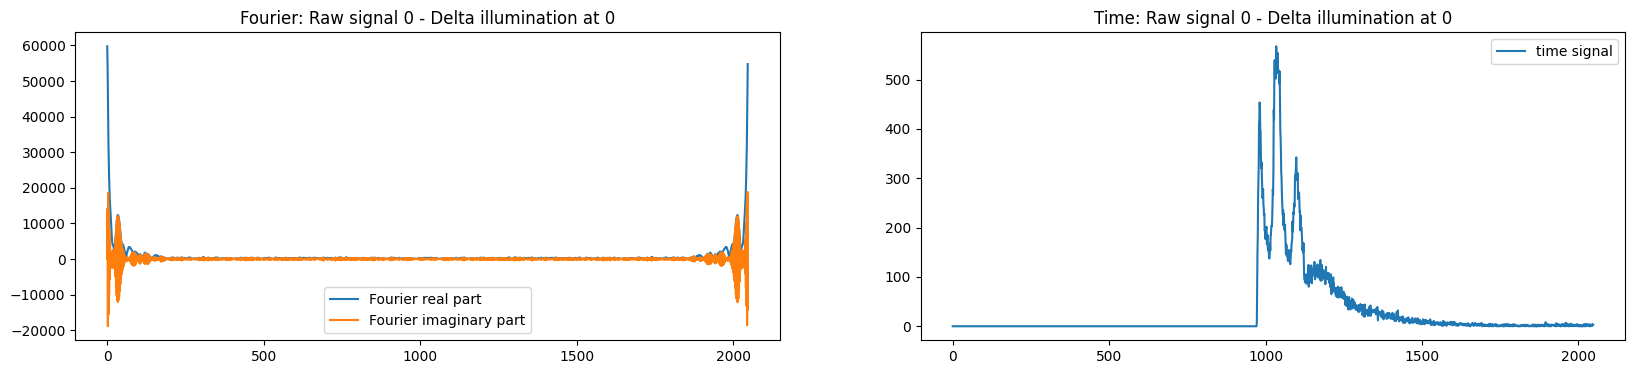

In [14]:
plot_pair_fourier_time(hat_s[0][None,:], 'Raw signal', ['Delta illumination at 0'])

### Illumination pulses

$$ \ket{\hat{l}_n} $$

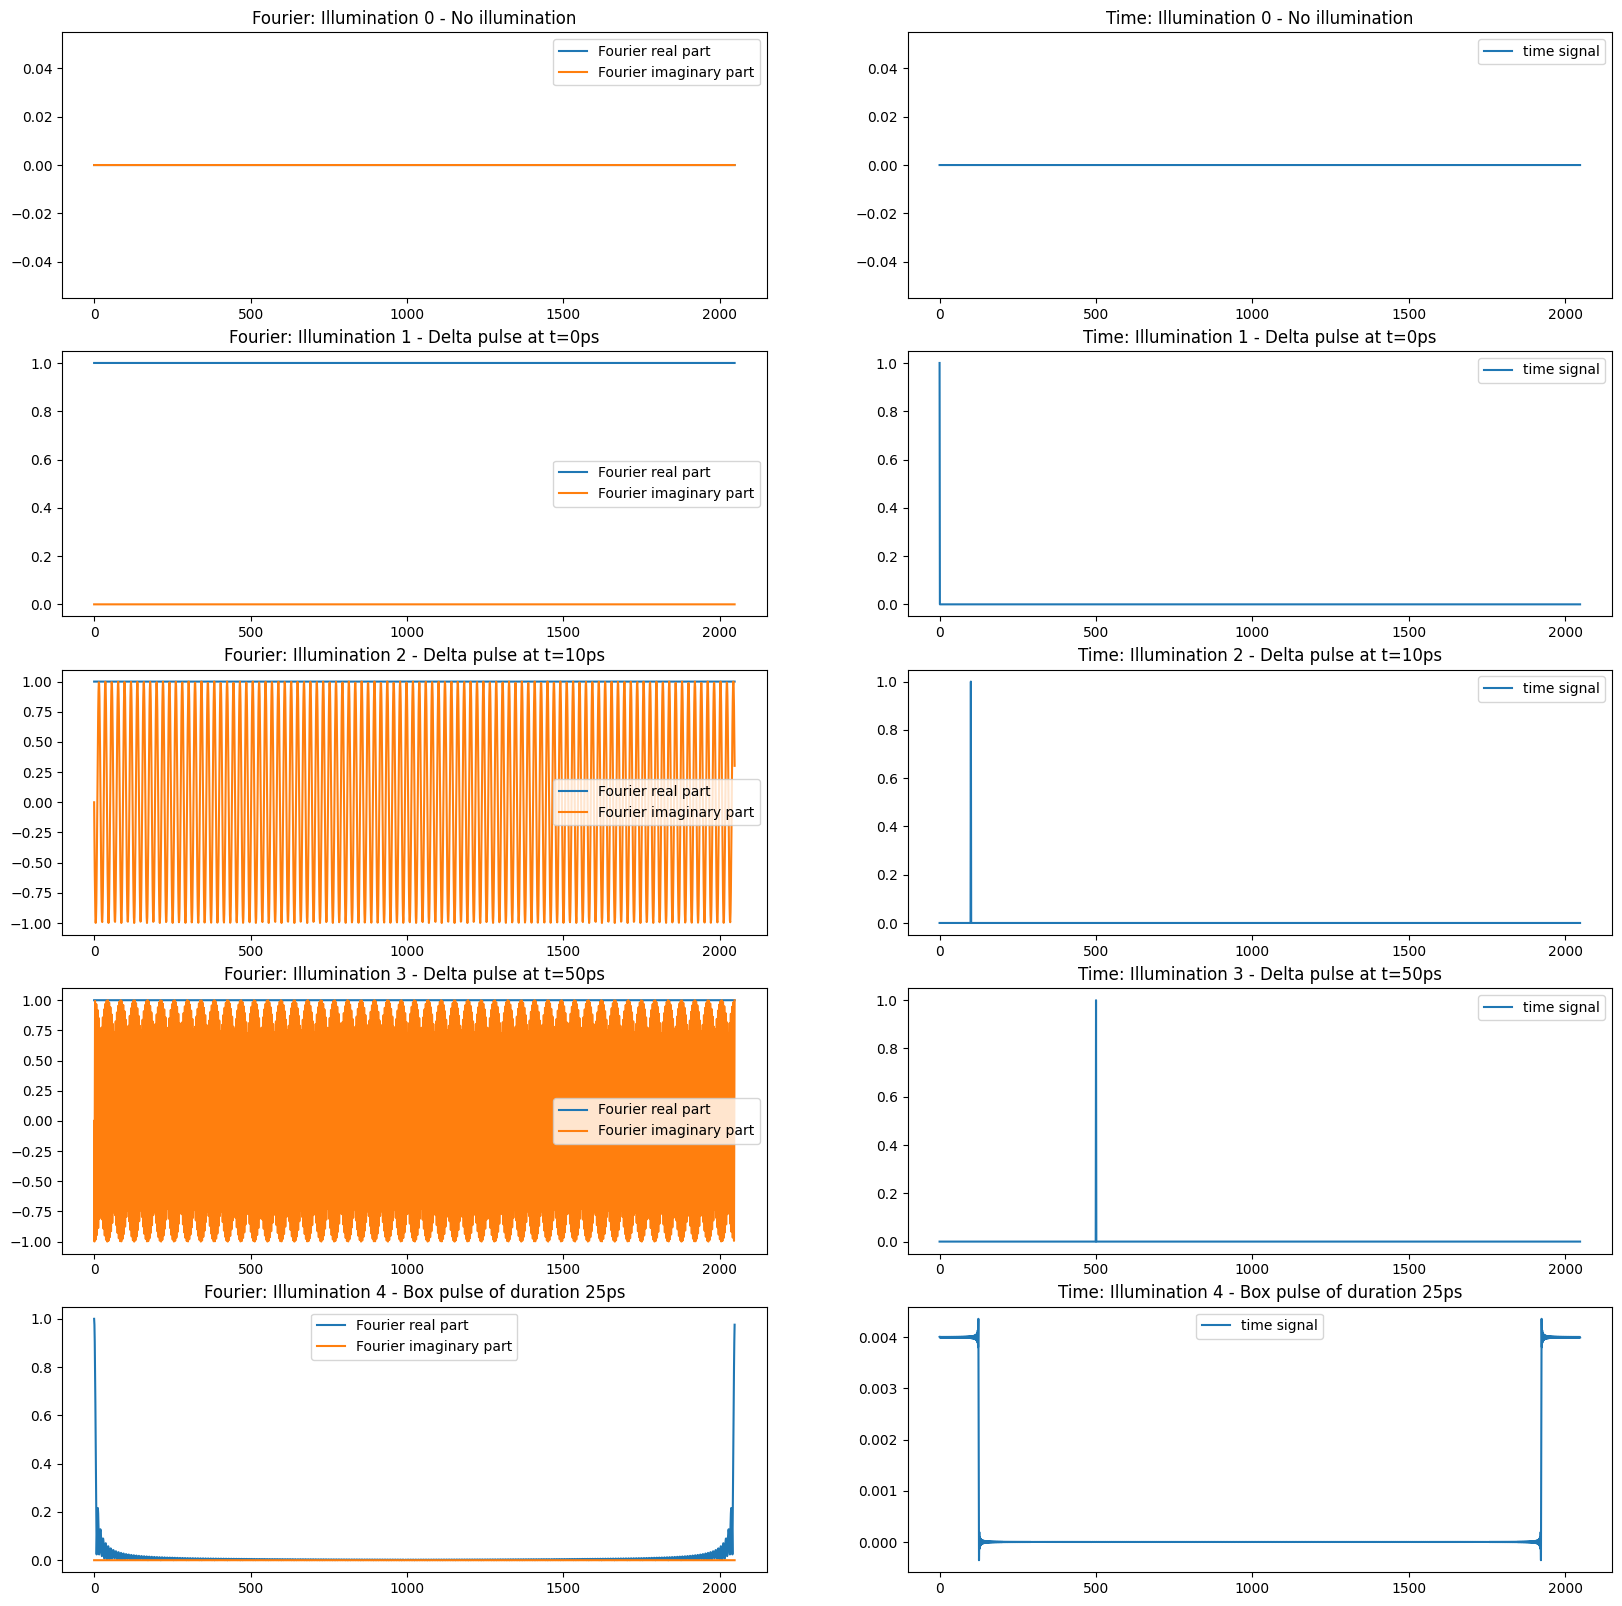

In [15]:
plot_pair_fourier_time(hat_l, 'Illumination', illumination_tag)

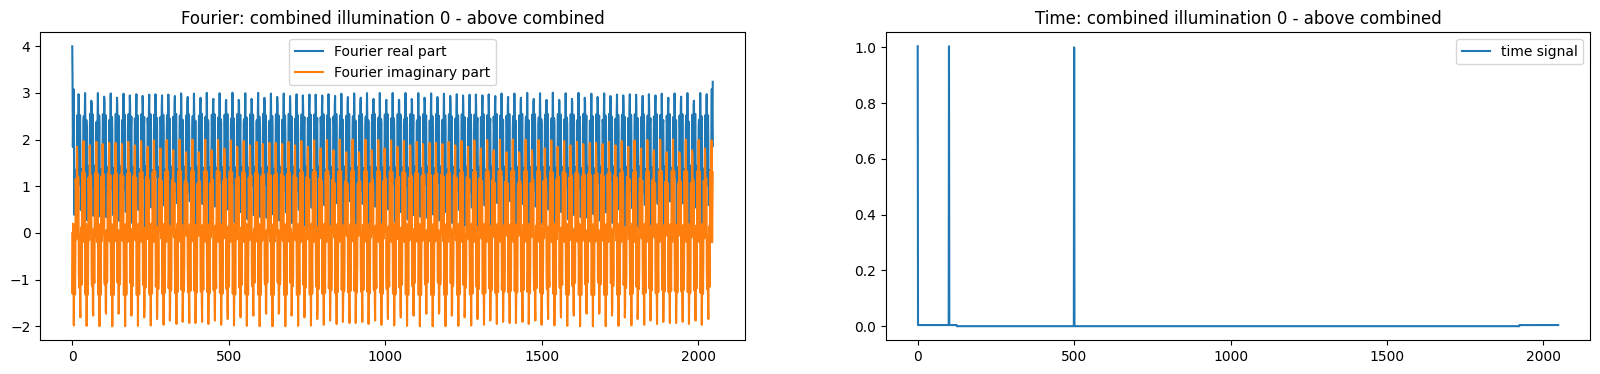

In [16]:
plot_pair_fourier_time(np.sum(hat_l,axis = 0).reshape(1,-1), 'combined illumination', ['above combined'])

### Signal response by the illuminated pulses

$$ \hat{T}_{m,n} = \ket{\hat{s}_m}\bra{\hat{l}_n}$$

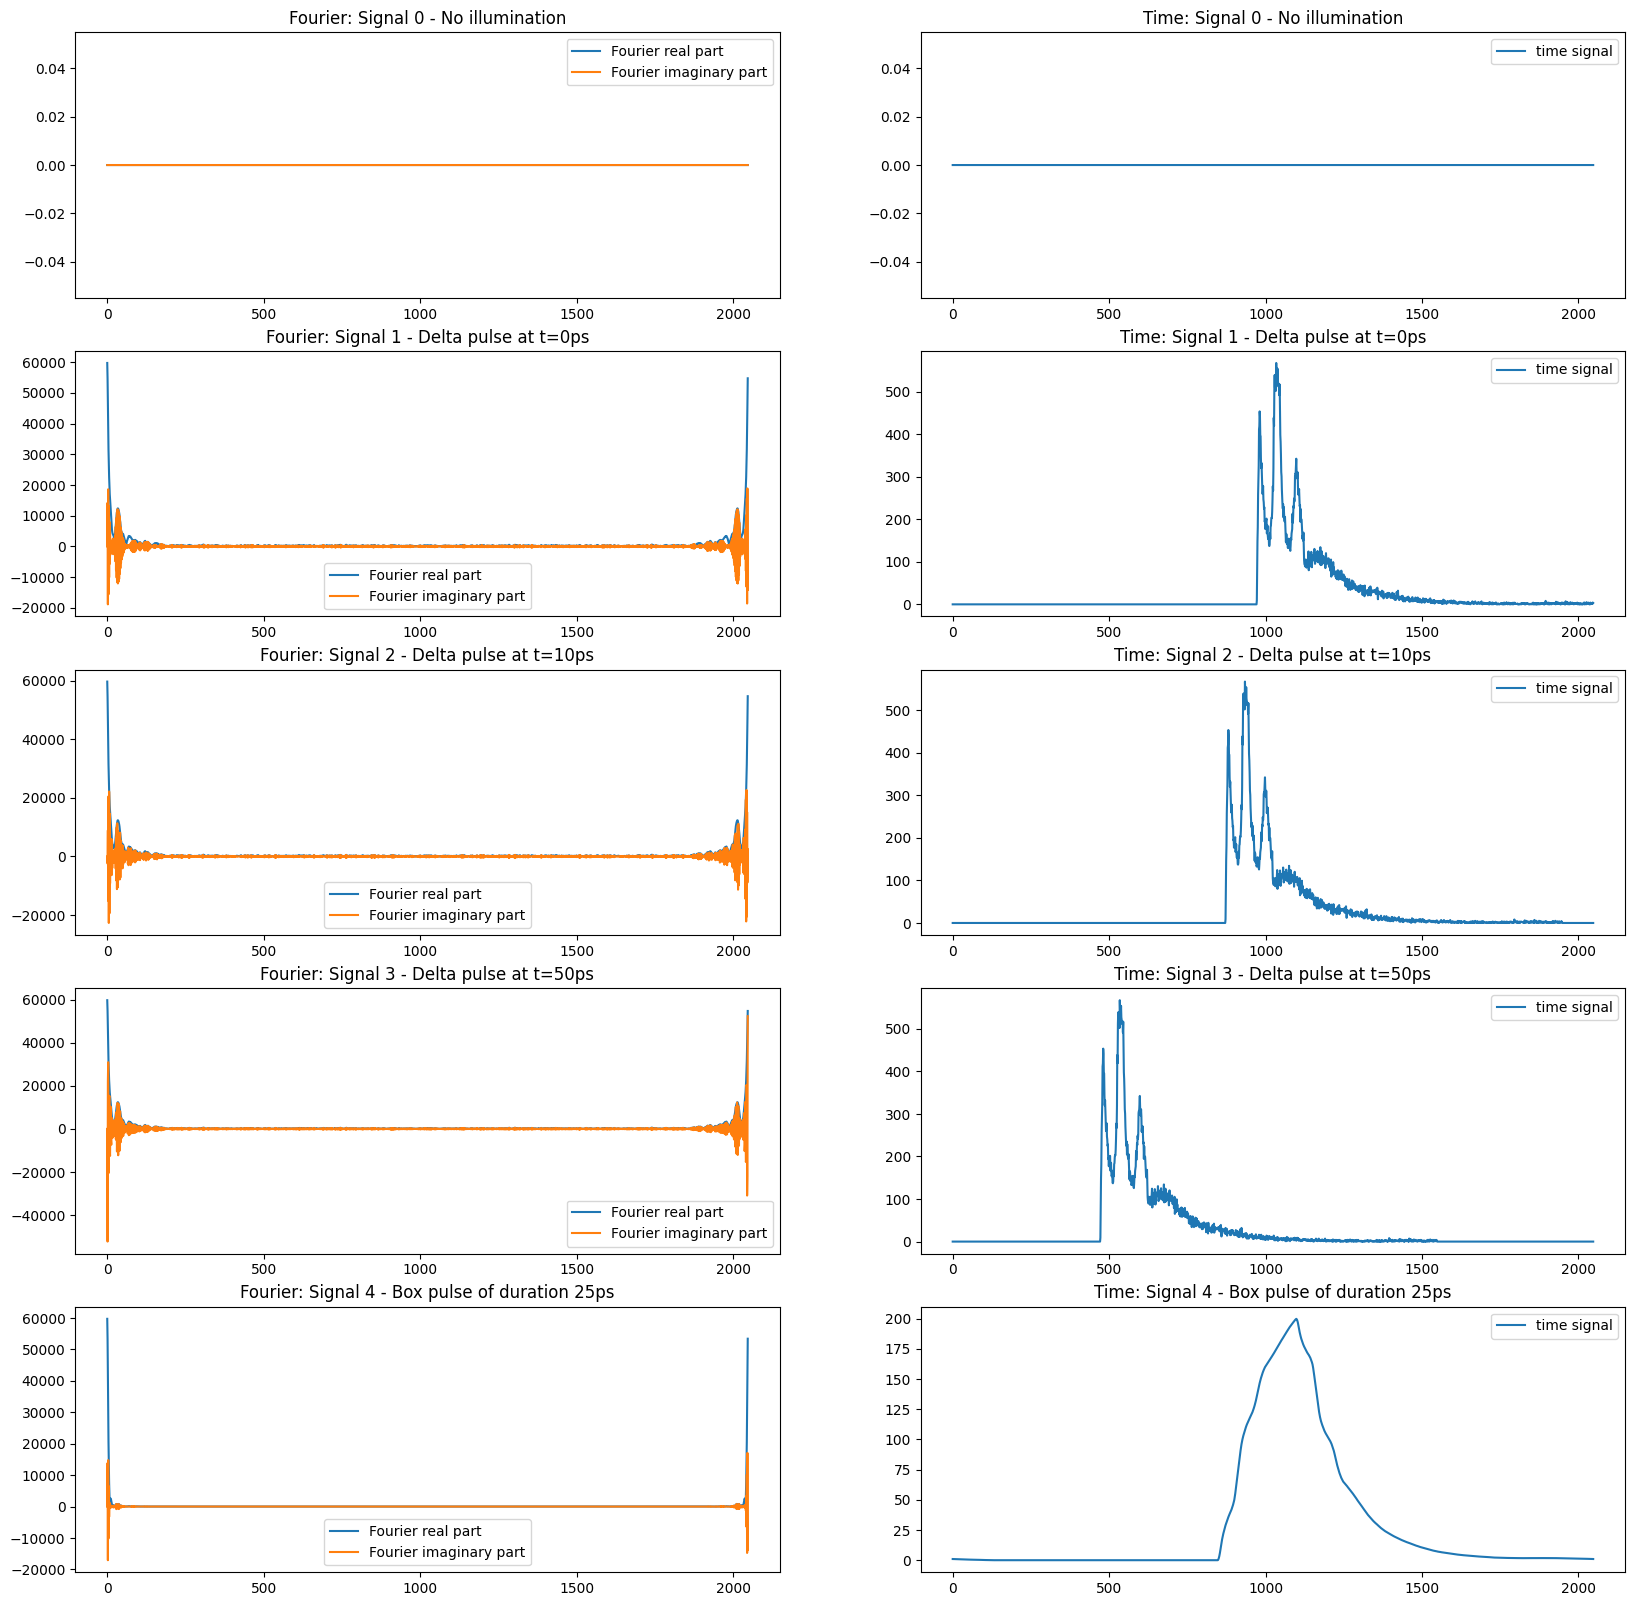

In [17]:
plot_pair_fourier_time(observations[0], 'Signal', illumination_tag)

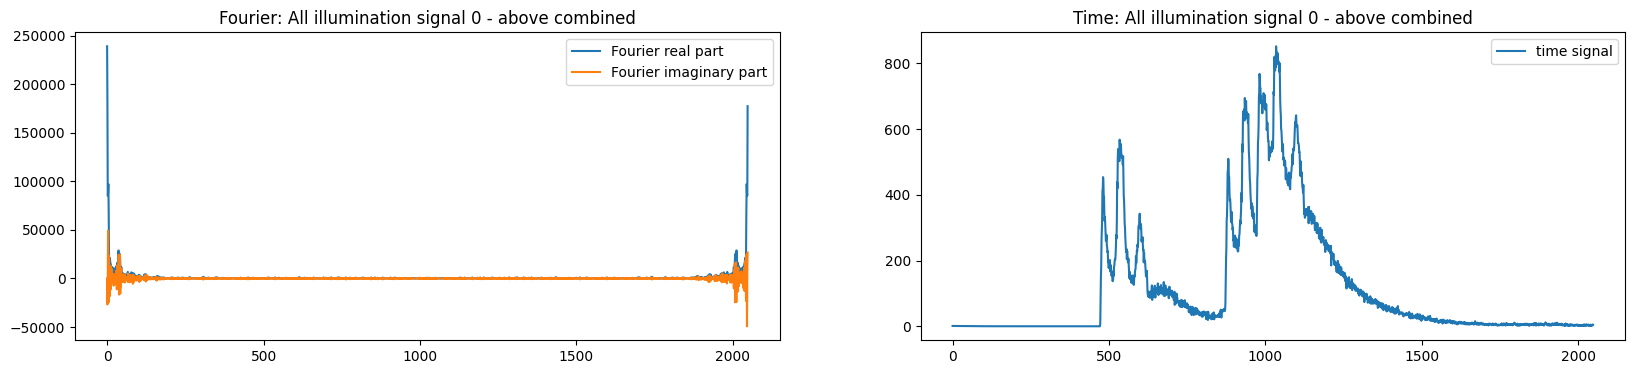

In [18]:
plot_pair_fourier_time(single_observation[0], 'All illumination signal', ['above combined'])

### Decoupled signal from the illumination

$$ \ket{\hat{s}_m} = (\bra{\hat{l}_n} \hat{T}^\dagger_{m,n})^\dagger  = (\braket{\hat{l}_n|\hat{l}_n}\bra{\hat{s}_m})^\dagger$$
Above line does not work. Calculated as $ \ket{\hat{s}_m} = (\hat{T}^\dagger_{m,n} / \ket{\hat{l}_n})^\dagger $

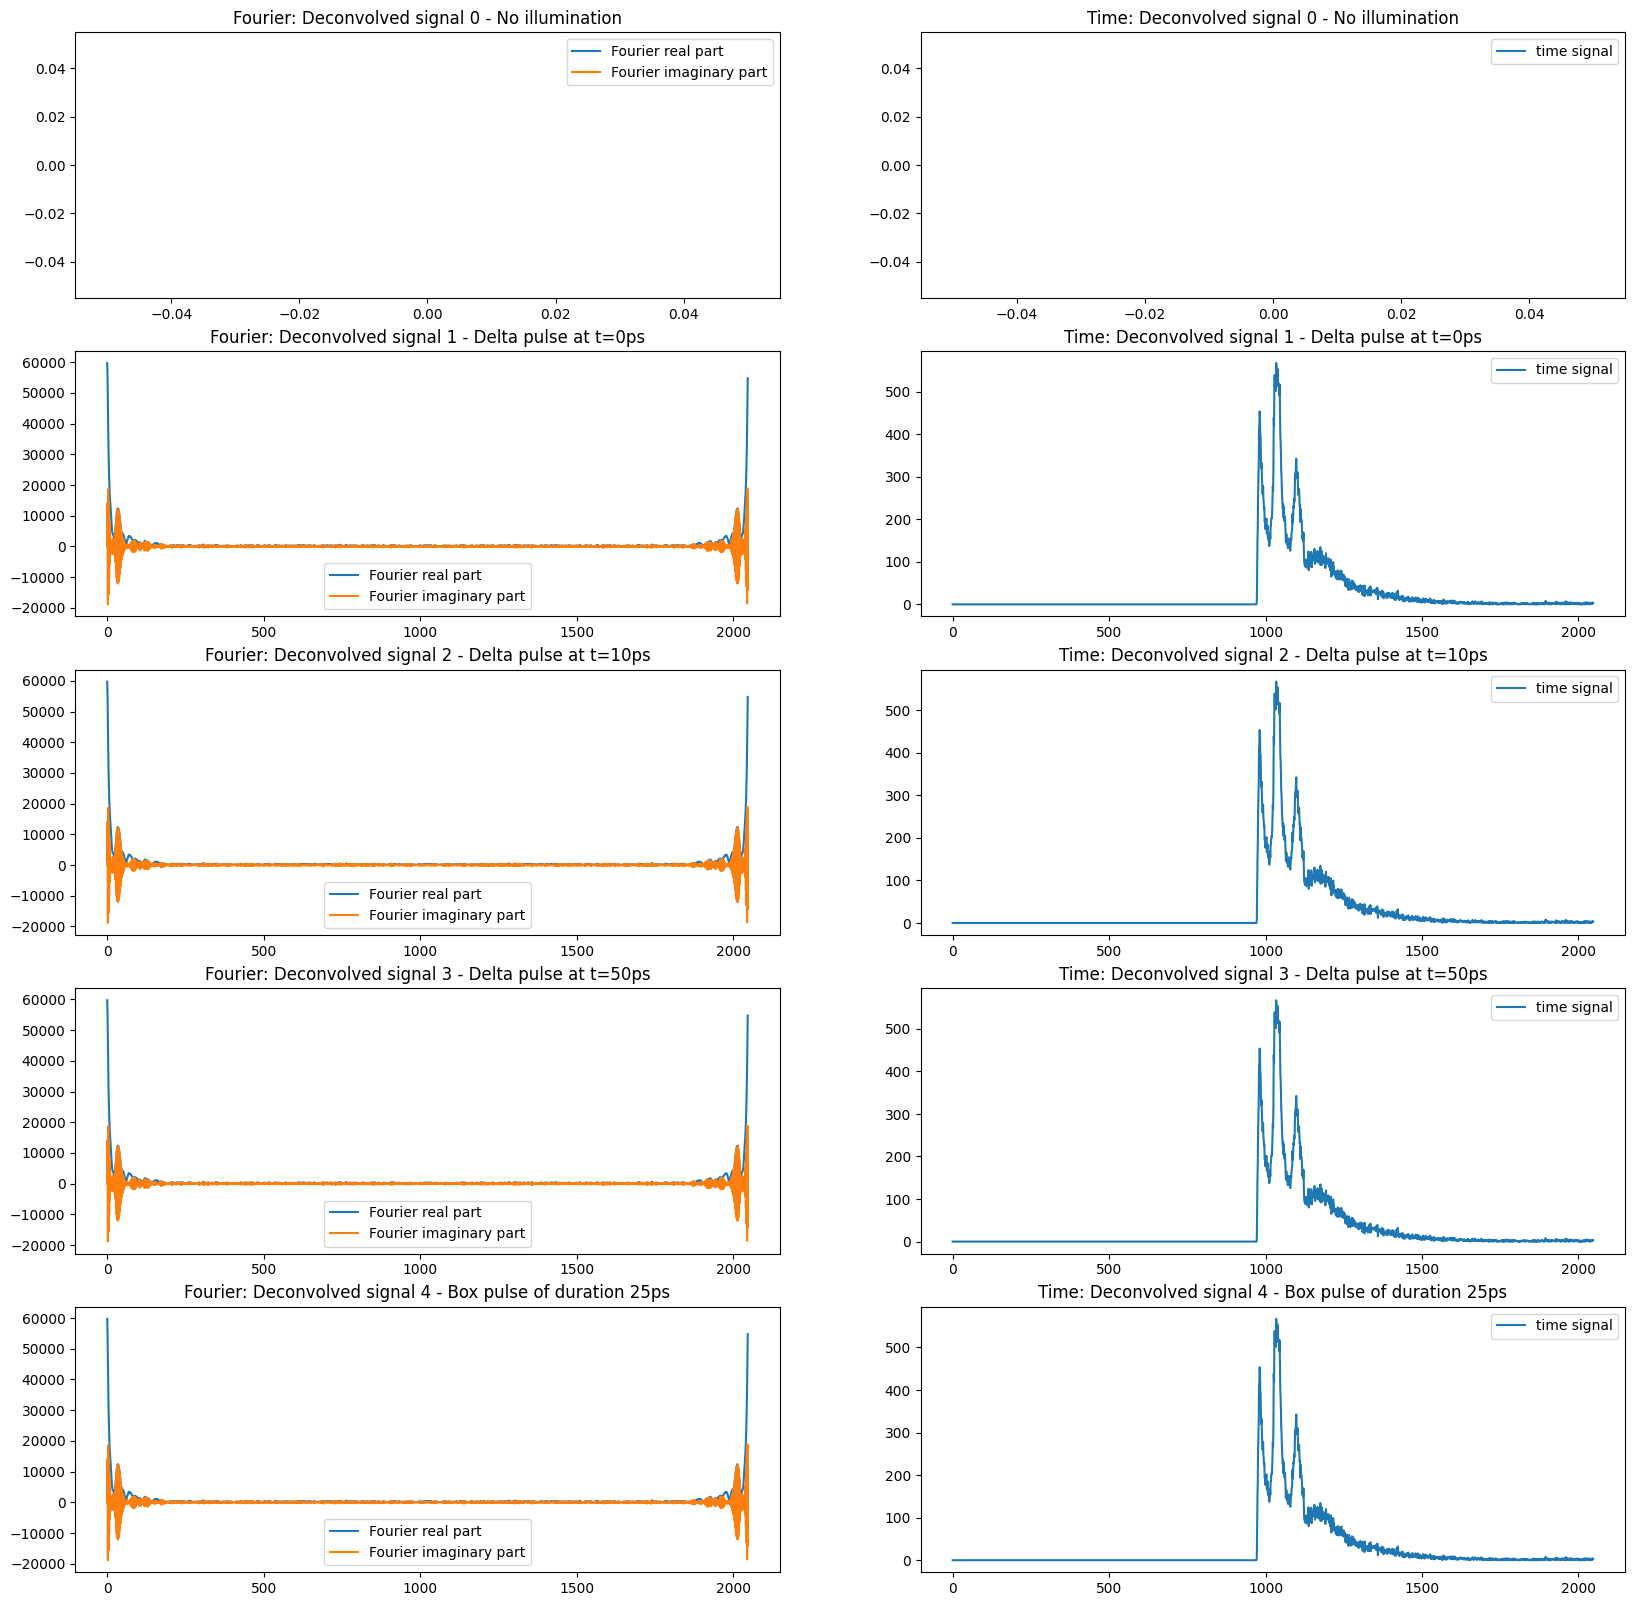

In [19]:
plot_pair_fourier_time(sensor_illuminated[0], 'Deconvolved signal', illumination_tag)

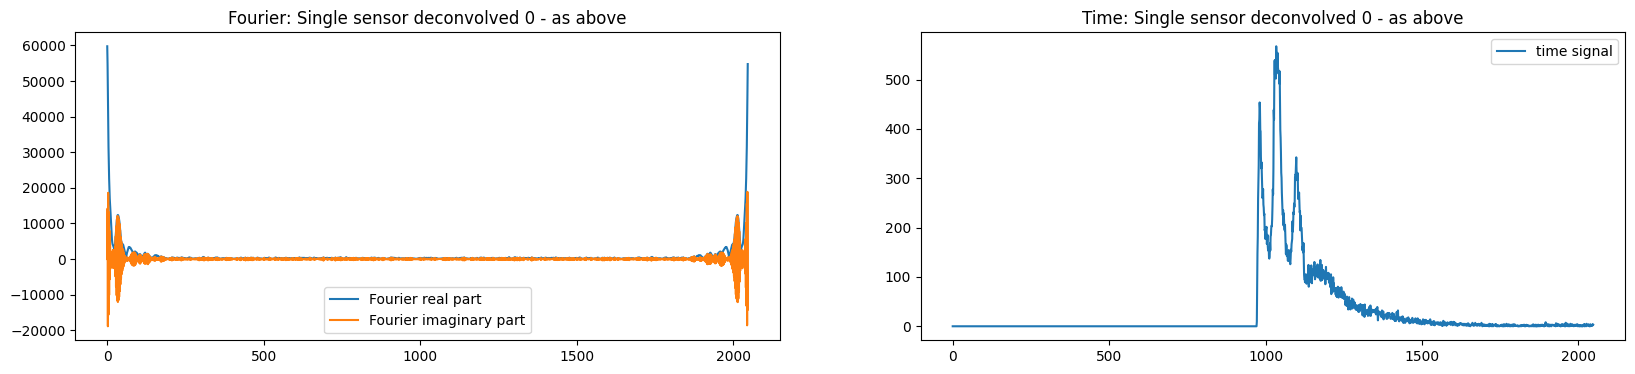

In [20]:
plot_pair_fourier_time(sensor_combined_illumination[0], 'Single sensor deconvolved', ['as above'])